# 3b. Fitting carbonate and SO$_2$ peaks
- This notebook shows how to fit secondary peaks, such as carbonate and S-rich phases in vapour bubbles and fluid inclusions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from tqdm import tqdm
import os
pf.__version__

'0.0.59'

In [2]:
MasterFolder = r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018"
DayFolder = os.path.join(MasterFolder, "Leilani_2018FI_Oct2122pictures for review")

meta_path=DayFolder +  '\Metadata'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'

if not os.path.exists(MasterFolder + '\OUTPUT'):
    os.mkdir(MasterFolder +'\OUTPUT')


In [3]:
# This specifies what file type your Raman exported in. 
filetype='headless_txt' # Specifies raman file format 
file_ext='.txt'
prefix=False
file_ext='.txt'
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'Spec', 'CRR', 'secphase','series','FO','de']
Diad_Files=pf.get_files(path=spectra_path, file_ext=file_ext, exclude_str=exclude_str)
print(Diad_Files)
File_df=pd.DataFrame(data={'filename': Diad_Files})

['LL4-21-MI#1.txt', 'LL4-21-MI#2.txt', 'LL4-21-MI#3.txt', 'LL4-21-MI#4.txt', 'LL4-21-MI#5.txt', 'LL4-21-MI#6.txt', 'LL4-FI3-4-MI#1.txt', 'LL4-FI3-4-MI#2.txt', 'LL7-31-MI#1 (1).txt', 'LL7-31-MI#1.txt', 'LL7-FI16-MI#1.txt', 'LL7-FI16-MI#2.txt', 'LL7-FI27-MI#3.txt']


## Plot spectra in a given region of space to examine secondary peaks or not

### You'll need to tweak the peak parameters to find them
- height = minimum height a peak should have to be identified
- threshold = required vertical distance between a peak and its neighbours
- distance = required horizontal distance bewteen neighbouring peaks. 
- prominence = required prominence of peaks
- width = width of peaks


### Two options to ID peaks 
- the first is to use the sigma parameter, it finds the max position, and then within +-10 of that, finds the median, if the peak is sigma*the standard deviation above that it uses it 

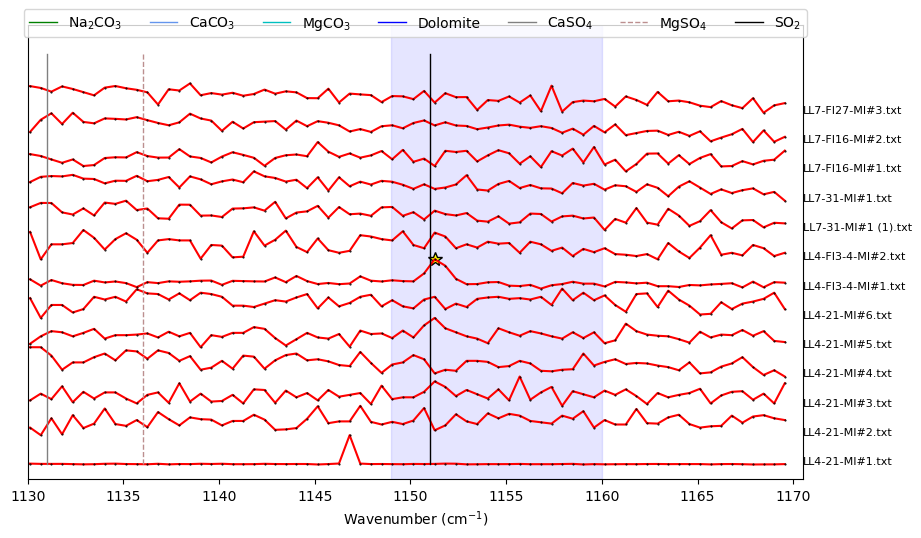

In [4]:
SO2_peaks_sigma, x_data_sigma, y_data_sigma, fig_sigma=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, 
path=spectra_path, 
filetype=filetype,  sigma_filter=True, sigma=3, 
xlim_peaks=[1149, 1160], xlim_plot=[1130, 1170], yscale=0.3)
fig_sigma.savefig('SO2_Peaks.png', dpi=300)

- Alternatively, you can use scipy find peaks, with the same peak parameters as used throughout Diad Fit

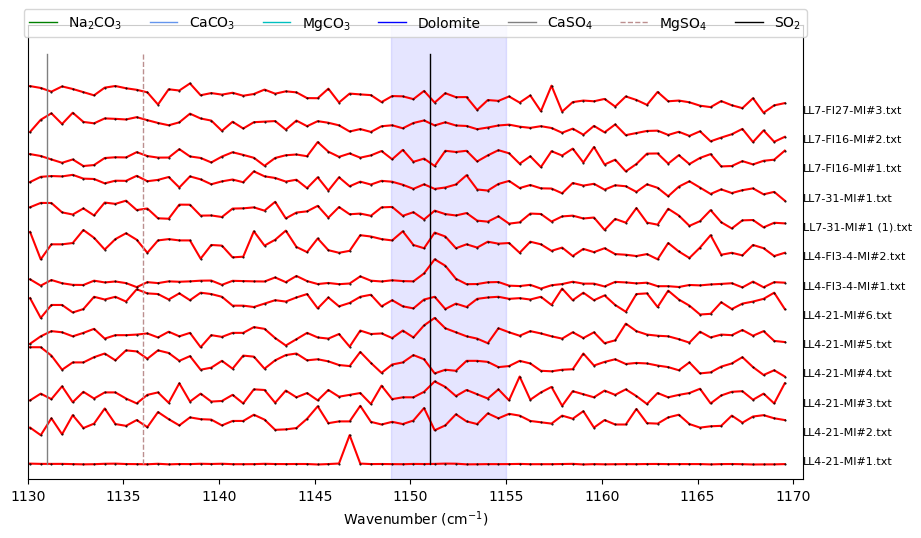

In [5]:
prominence_SO2=100
height_SO2=10
width_SO2=2
threshold_SO2=1

SO2_peaks_scipy, x_data_scipy, y_data_scipy, fig_scipy=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
filetype=filetype, find_peaks_filter=True,  
xlim_peaks=[1149, 1155], xlim_plot=[1130, 1170], yscale=0.3,
prominence=prominence_SO2, height=height_SO2, width=width_SO2, threshold=threshold_SO2)


### Choose whether to use scipy or sigma here

In [6]:
scipy=False

if scipy is True:
    SO2_peaks=SO2_peaks_scipy
else:
    SO2_peaks=SO2_peaks_sigma

## Find peaks filtering on peak position and prominence so just loop through these files

In [7]:
SO2_notNa=np.isnan(SO2_peaks['pos'])
SO2_filter=((SO2_peaks['pos'].between(1140, 1160))&(SO2_peaks['prom']>10))&(~SO2_notNa)
print('Number kept with this filter:')
print(sum(SO2_filter))
print('Number discarded:')
print(sum(~SO2_filter&(~SO2_notNa)))
filenames_SO2=list(File_df['filename'].loc[SO2_filter])
print('filenames with SO2:')
print(filenames_SO2)

Number kept with this filter:
1
Number discarded:
0
filenames with SO2:
['LL4-FI3-4-MI#1.txt']


### Choose a filename to test peak fits

In [8]:
if sum(SO2_filter)>0:
    filename=filenames_SO2[0]

### Set up configuration file for S peak fitting

generic_peak_config(name='SO2', lower_bck=[1110, 1130], upper_bck=[1160, 1180], model_name='Spline', x_range_bck=5, N_poly_carb_bck=1, amplitude=1000, cent=1150, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=None, return_other_params=False, N_peaks=1)


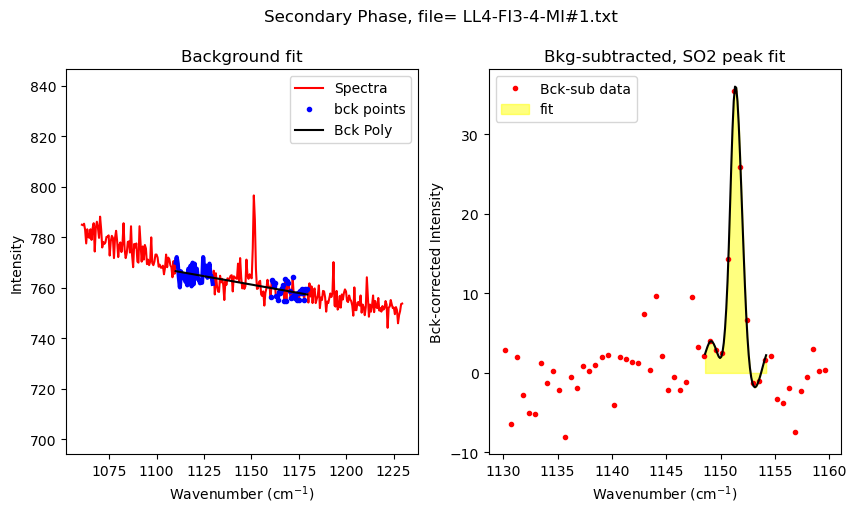

In [9]:
if sum(SO2_filter)>0:
    SO2_peak_config=pf.generic_peak_config(name='SO2', lower_bck=[1110, 1130],
    upper_bck=[1160, 1180], cent=1150, x_range_bck=5, N_peaks=1,   model_name='Spline')
    print(SO2_peak_config)

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
    path=spectra_path, filename=filename, filetype=filetype,
 
     plot_figure=True)
    SO2_peak_fit


## Now lets loop through files

100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

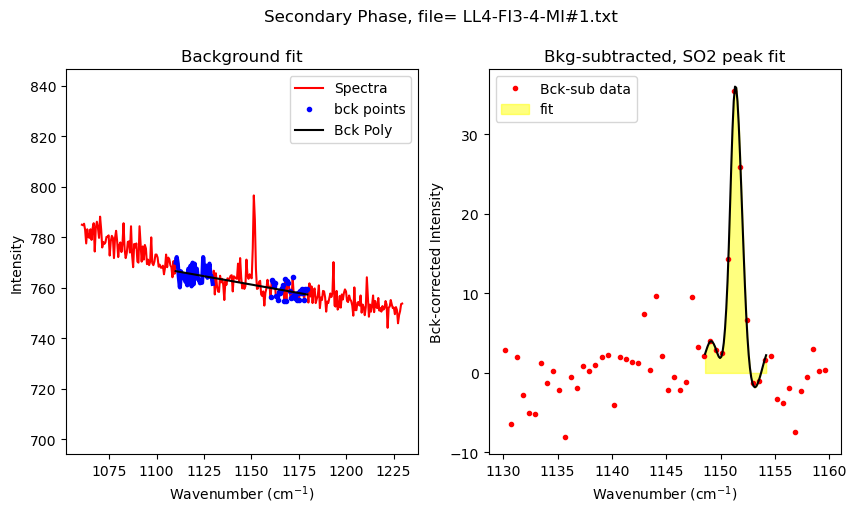

In [10]:
files_to_fit=filenames_SO2
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_SO2 = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
path=spectra_path, filename=filename, filetype=filetype,
 plot_figure=plot_figure)
 
    df_Merge_SO2 = pd.concat([df_Merge_SO2, SO2_peak_fit], axis=0)

### Plot peak areas and peak heights

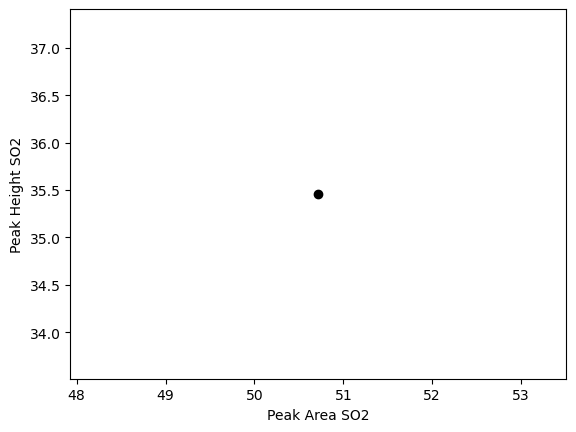

In [11]:
if sum(SO2_filter)>0:
    plt.plot(df_Merge_SO2['Peak_Area_SO2'], 
            df_Merge_SO2['Peak_Height_SO2'], 'ok')
    plt.xlabel('Peak Area SO2')
    plt.ylabel('Peak Height SO2')
    # plt.yscale('log')
# plt.xscale('log')

### Save this to excel

In [12]:
if sum(SO2_filter)>0:
    df_Merge_SO2.to_excel('SO2_Peak_fits.xlsx', index=False)

## Now do the same to ID any carbonate peaks

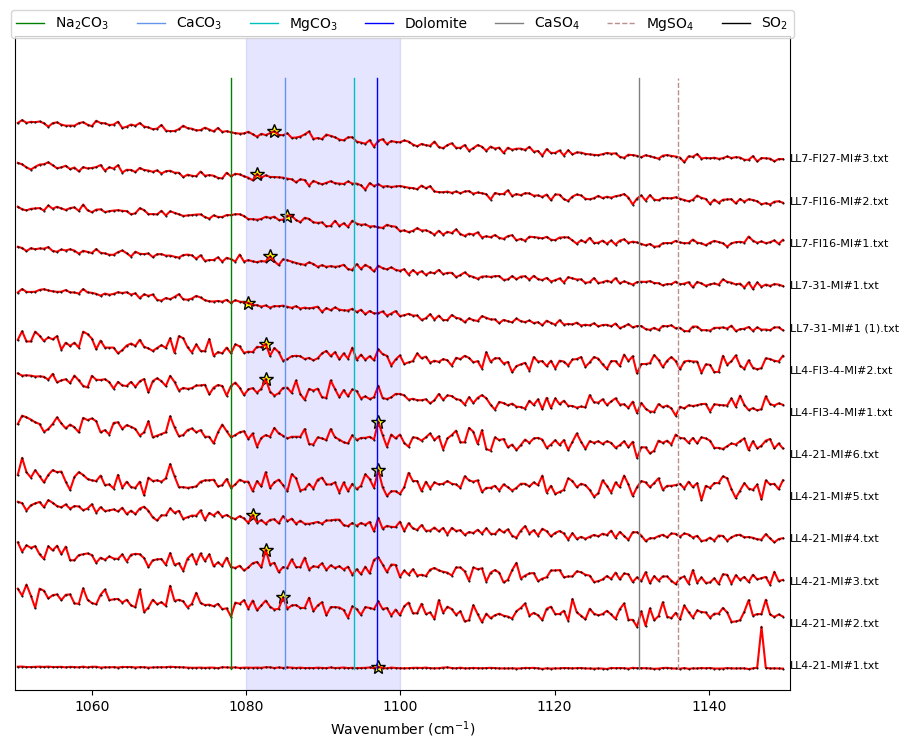

In [13]:
## Using Sigma method - doesnt work very well for carb
Carb_peaks_sigma, x_data_sigma, y_data_sigma, fig_sigma=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
filetype=filetype,  sigma_filter=True, sigma=1, 
xlim_plot=[1050, 1150], xlim_peaks=[1080, 1100], yscale=0.5)

## Using scipy find peaks methods

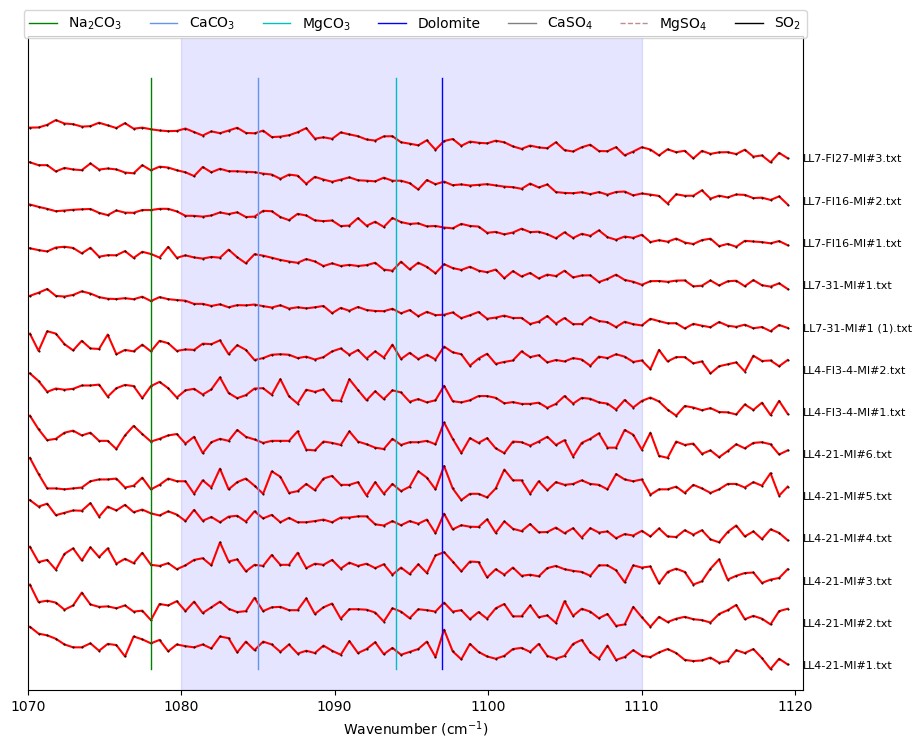

In [14]:

prominence_carb=20
height_carb=10
width_carb=5
threshold_carb=0

Carb_peaks_scipy, x_data_scipy, y_data_scipy, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=filetype, find_peaks_filter=True,  
xlim_plot=[1070, 1120], xlim_peaks=[1080, 1110], yscale=0.5,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)


### Decide whether Scipy or Sigma does a better job

In [15]:
scipy=True
sigma=False
if scipy is True:
    Carb_peaks=Carb_peaks_scipy
else:
    Carb_peaks=Carb_peaks_sigma

In [16]:
Carb_peaks['prom']

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
Name: prom, dtype: float64

## Find ones with certain peak parameters to include

In [17]:
Carb_noNa=np.isnan(Carb_peaks['pos'])
Carb_filter=((Carb_peaks['pos'].between(1080, 1100))&(Carb_peaks['prom']>10))&(~Carb_noNa)
print('Number kept with this filter:')
print(sum(Carb_filter))
print('Number discarded:')
print(sum(~Carb_filter&(~Carb_noNa)))
filenames_Carb=list(File_df['filename'].loc[Carb_filter])
print('filenames with carb:')
print(filenames_Carb)

Number kept with this filter:
0
Number discarded:
0
filenames with carb:
[]


### Fit one to tweak parameters

In [18]:
if sum(Carb_filter)>0:
    filename_carb=filenames_Carb[0]

    Carb_peak_config=pf.generic_peak_config(name='Carb', lower_bck=[1050, 1070],
    upper_bck=[1120, 1150], cent=1090, x_range_bck=50, N_poly_carb_bck=2)
    print(Carb_peak_config)

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
    path=spectra_path, filename=filename_carb, filetype=filetype,
     plot_figure=True)

### Loop over all carbonate files

In [19]:
files_to_fit=filenames_Carb
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_Carb = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
path=spectra_path, filename=filename, filetype=filetype,
 plot_figure=plot_figure)
 
    df_Merge_Carb = pd.concat([df_Merge_Carb, Carb_peak_fit], axis=0)

0it [00:00, ?it/s]


In [20]:
if sum(Carb_filter)>0:
    plt.plot(df_Merge_Carb['Peak_Area_Carb'], 
        df_Merge_Carb['Peak_Height_Carb'], 'ok')
    plt.xlabel('Peak Area SO2')
    plt.ylabel('Peak Height SO2')
# plt.yscale('log')
# plt.xscale('log')

## Save to excel

In [21]:
if sum(Carb_filter)>0:
    df_Merge_Carb.to_excel('Carb_Peak_fits.xlsx', index=False )

In [22]:
from winotify import Notification, audio

toast= Notification(app_id="VSCode",title="Notebook completed",
                    msg="Step3b_Secondary_Peaks is done!",
                    duration="short")
toast.set_audio(audio.Mail,loop=False)
toast.show()